<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/W10_BasicNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks

Let's start with a simple SciKit MLClassifier example with the MNIST data.

Iteration 1, loss = 0.32043346
Iteration 2, loss = 0.15355752
Iteration 3, loss = 0.11542871
Iteration 4, loss = 0.09324411
Iteration 5, loss = 0.07912576
Iteration 6, loss = 0.07138717
Iteration 7, loss = 0.06214091
Iteration 8, loss = 0.05551503
Iteration 9, loss = 0.05028847
Iteration 10, loss = 0.04586576


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.986850
Test set score: 0.970700


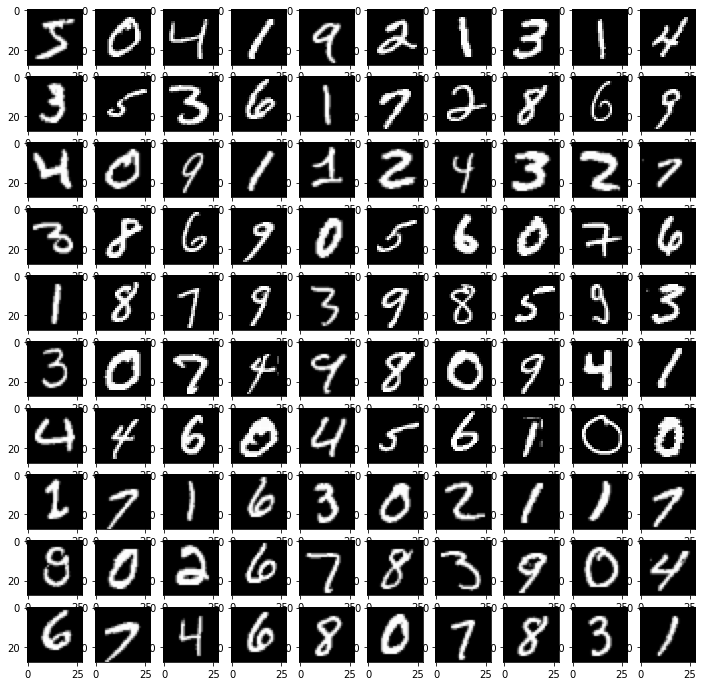

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

plt.figure(figsize=(12, 12))

for img in range(100):
  ax = plt.subplot(10, 10, img+1)
  plt.imshow(X[img].reshape(28,28), cmap='gray')

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

In [ ]:
mlp.predict(X_test)

array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1')

In [ ]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [ ]:
# MNist example based on https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/image/mnist.html

# This is a fairly elaborate convolutional neural network,
# which is built, trained, and tested.

import mxnet as mx
import mxnet.ndarray as F
from __future__ import print_function

from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag

# Fixing the random seed
mx.random.seed(42)

mnist = mx.test_utils.get_mnist()

batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(500))
  net.add(nn.Dense(10))

ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

# Training
epochs = 15

for i in range(epochs):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: %s=%f'%metric.get())


training acc at epoch 0: accuracy=0.852967
training acc at epoch 1: accuracy=0.900433
training acc at epoch 2: accuracy=0.909167
training acc at epoch 3: accuracy=0.912983
training acc at epoch 4: accuracy=0.915700
training acc at epoch 5: accuracy=0.918217
training acc at epoch 6: accuracy=0.919683
training acc at epoch 7: accuracy=0.920517
training acc at epoch 8: accuracy=0.921467
training acc at epoch 9: accuracy=0.922583
training acc at epoch 10: accuracy=0.923717
training acc at epoch 11: accuracy=0.924000
training acc at epoch 12: accuracy=0.924517
training acc at epoch 13: accuracy=0.925183
training acc at epoch 14: accuracy=0.925767
validation acc: accuracy=0.924700
